# 1. Setup

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18

tqdm.pandas()

/opt/conda/lib/python3.7/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [2]:
language = 'Malayalam'
data_dir = f'Data/{language}'
train_dir = f'{data_dir}/Train'
val_dir = f'{data_dir}/Val'
test_dir = f'{data_dir}/Test'
test_dir_v2 = f'Data/{language}-V2-Test'

In [3]:
character_df_fp = f'Data/Characters/Characters-{language}.csv'

In [4]:
cpu_count = 8 #os.cpu_count()
print(cpu_count)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

8
cuda


# 2. Define character class

In [5]:
character_df = pd.read_csv(character_df_fp)
print(character_df.shape)
character_df.head()

(668, 3)


,Character,Consonant,Glyph
0,അ,-,-
1,ആ,-,ാ
2,ഇ,-,ി
3,ഈ,-,ീ
4,ഉ,-,ു


In [6]:
#character_df[character_df['Consonant']=="-"]

In [7]:
characters = set()
for character in character_df['Character'].values:
    characters.update(list(character))
characters = ["-"] + sorted(list(characters))
print(len(characters))
print(characters)

74
['-', 'ഀ', 'ഁ', 'ഃ', 'അ', 'ആ', 'ഇ', 'ഈ', 'ഉ', 'ഊ', 'ഋ', 'ഌ', 'എ', 'ഏ', 'ഐ', 'ഒ', 'ഓ', 'ഔ', 'ക', 'ഖ', 'ഗ', 'ഘ', 'ങ', 'ച', 'ഛ', 'ജ', 'ഝ', 'ഞ', 'ട', 'ഠ', 'ഡ', 'ഢ', 'ണ', 'ത', 'ഥ', 'ദ', 'ധ', 'ന', 'പ', 'ഫ', 'ബ', 'ഭ', 'മ', 'യ', 'ര', 'റ', 'ല', 'ള', 'ഴ', 'വ', 'ശ', 'ഷ', 'സ', 'ഹ', 'ാ', 'ി', 'ീ', 'ു', 'ൂ', 'ൃ', 'െ', 'േ', 'ൈ', 'ൊ', 'ോ', 'ൌ', '്', 'ൢ', 'ൺ', 'ൻ', 'ർ', 'ൽ', 'ൾ', 'ൿ']


In [8]:
idx2char = {k:v for k,v in enumerate(characters)}
print(idx2char)
char2idx = {v:k for k,v in idx2char.items()}
print(char2idx)

{0: '-', 1: 'ഀ', 2: 'ഁ', 3: 'ഃ', 4: 'അ', 5: 'ആ', 6: 'ഇ', 7: 'ഈ', 8: 'ഉ', 9: 'ഊ', 10: 'ഋ', 11: 'ഌ', 12: 'എ', 13: 'ഏ', 14: 'ഐ', 15: 'ഒ', 16: 'ഓ', 17: 'ഔ', 18: 'ക', 19: 'ഖ', 20: 'ഗ', 21: 'ഘ', 22: 'ങ', 23: 'ച', 24: 'ഛ', 25: 'ജ', 26: 'ഝ', 27: 'ഞ', 28: 'ട', 29: 'ഠ', 30: 'ഡ', 31: 'ഢ', 32: 'ണ', 33: 'ത', 34: 'ഥ', 35: 'ദ', 36: 'ധ', 37: 'ന', 38: 'പ', 39: 'ഫ', 40: 'ബ', 41: 'ഭ', 42: 'മ', 43: 'യ', 44: 'ര', 45: 'റ', 46: 'ല', 47: 'ള', 48: 'ഴ', 49: 'വ', 50: 'ശ', 51: 'ഷ', 52: 'സ', 53: 'ഹ', 54: 'ാ', 55: 'ി', 56: 'ീ', 57: 'ു', 58: 'ൂ', 59: 'ൃ', 60: 'െ', 61: 'േ', 62: 'ൈ', 63: 'ൊ', 64: 'ോ', 65: 'ൌ', 66: '്', 67: 'ൢ', 68: 'ൺ', 69: 'ൻ', 70: 'ർ', 71: 'ൽ', 72: 'ൾ', 73: 'ൿ'}
{'-': 0, 'ഀ': 1, 'ഁ': 2, 'ഃ': 3, 'അ': 4, 'ആ': 5, 'ഇ': 6, 'ഈ': 7, 'ഉ': 8, 'ഊ': 9, 'ഋ': 10, 'ഌ': 11, 'എ': 12, 'ഏ': 13, 'ഐ': 14, 'ഒ': 15, 'ഓ': 16, 'ഔ': 17, 'ക': 18, 'ഖ': 19, 'ഗ': 20, 'ഘ': 21, 'ങ': 22, 'ച': 23, 'ഛ': 24, 'ജ': 25, 'ഝ': 26, 'ഞ': 27, 'ട': 28, 'ഠ': 29, 'ഡ': 30, 'ഢ': 31, 'ണ': 32, 'ത': 33, 'ഥ': 34, 'ദ': 35, 'ധ': 36, 'ന': 37, 'പ': 38, '

# 3. Define data loader

In [9]:
class IndianSceneTextDataset(Dataset):
    
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.image_fns = os.listdir(data_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        image_fp = os.path.join(self.data_dir, image_fn)
        image = Image.open(image_fp).convert('RGB')
        image = self.transform(image)
        text = image_fn.split("_")[0][:13]
        return image, text, image_fn
    
    def transform(self, image):
        
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])
        return transform_ops(image)

In [10]:
def tokenize(text):

    text_tokens = list(text)
    
    return text_tokens

# 4. Define model

In [11]:
resnet = resnet18(pretrained=True)
#print(resnet)

In [12]:
for p in resnet.parameters():
    p.requires_grad = False

In [13]:
class CRNN(nn.Module):
    
    def __init__(self, num_chars, rnn_hidden_size=256):
        
        super(CRNN, self).__init__()
        self.num_chars = num_chars
        self.rnn_hidden_size = rnn_hidden_size
        self.dp1 = nn.Dropout(p=0.5)
        self.dp2 = nn.Dropout(p=0.5)
        self.dp3 = nn.Dropout(p=0.5)
        
        # CNN Part 1
        resnet_modules = list(resnet.children())[:-3]
        self.cnn_p1 = nn.Sequential(*resnet_modules)
        
        # CNN Part 2
        self.cnn_p2 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.linear1 = nn.Linear(1024, 256)
        
        # RNN
        self.rnn1 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True, 
                            num_layers=2,
                            batch_first=True)
        self.rnn2 = nn.GRU(input_size=rnn_hidden_size, 
                            hidden_size=rnn_hidden_size,
                            bidirectional=True,
                            num_layers=1, 
                            batch_first=True)
        self.linear2 = nn.Linear(self.rnn_hidden_size*2, num_chars)
        
        
    def forward(self, batch):
        
        batch = self.cnn_p1(batch)
        # print(batch.size()) # torch.Size([-1, 256, 4, 13])
        
        batch = self.cnn_p2(batch) # [batch_size, channels, height, width]
        batch = self.dp1(batch)
        # print(batch.size())# torch.Size([-1, 256, 4, 13])
        
        batch = batch.permute(0, 3, 1, 2) # [batch_size, width, channels, height]
        # print(batch.size()) # torch.Size([-1, 13, 256, 4])
        
        batch_size = batch.size(0)
        T = batch.size(1)
        batch = batch.view(batch_size, T, -1) # [batch_size, T==width, num_features==channels*height]
        # print(batch.size()) # torch.Size([-1, 13, 1024])
        
        batch = self.linear1(batch)
        batch = self.dp2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn1(batch)
        feature_size = batch.size(2)
        batch = batch[:, :, :feature_size//2] + batch[:, :, feature_size//2:]
        # print(batch.size()) # torch.Size([-1, 13, 256])
        
        batch, hidden = self.rnn2(batch)
        batch = self.dp3(batch)
        # print(batch.size()) # torch.Size([-1, 13, 512])
        
        batch = self.linear2(batch)
        # print(batch.size()) # torch.Size([-1, 13, 375])
        
        batch = batch.permute(1, 0, 2) # [T, batch_size, num_classes==num_features]
        # print(batch.size()) # torch.Size([13, -1, 375])
        
        return batch

# 5. Make predictions

In [14]:
batch_size = 64
rnn_hidden_size = 256

In [15]:
trainset = IndianSceneTextDataset(train_dir) 
valset = IndianSceneTextDataset(val_dir)
testset = IndianSceneTextDataset(test_dir)
testset_v2 = IndianSceneTextDataset(test_dir_v2)

train_loader = DataLoader(trainset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
val_loader = DataLoader(valset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader = DataLoader(testset, batch_size=batch_size, num_workers=cpu_count, shuffle=False)
test_loader_v2 = DataLoader(testset_v2, batch_size=batch_size, num_workers=cpu_count, shuffle=False)

In [16]:
model_path = f'Models/{language}-Unicode-e40.pth'

crnn = CRNN(len(char2idx), rnn_hidden_size=rnn_hidden_size)
crnn.load_state_dict(torch.load(model_path))
crnn = crnn.to(device)
crnn.eval()

CRNN(
  (dp1): Dropout(p=0.5, inplace=False)
  (dp2): Dropout(p=0.5, inplace=False)
  (dp3): Dropout(p=0.5, inplace=False)
  (cnn_p1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(

In [17]:
def decode_predictions(text_batch_logits):

    text_batch_tokens = F.softmax(text_batch_logits, 2).argmax(2) # [T, batch_size]
    text_batch_tokens = text_batch_tokens.numpy().T # [batch_size, T]

    text_batch_tokens_new = []
    for text_tokens in text_batch_tokens:
        text = [idx2char[idx] for idx in text_tokens]
        text = "".join(text)
        text_batch_tokens_new.append(text)

    return text_batch_tokens_new

In [18]:
def make_predictions(data_loader):
    result = pd.DataFrame(columns=['image_fn', 'actual', 'prediction'])
    with torch.no_grad():
        for image_batch, text_batch, image_fn_batch in tqdm(data_loader, leave=False):
            text_batch_logits = crnn(image_batch.to(device)) # [T, batch_size, num_classes==num_features]
            text_batch_pred = decode_predictions(text_batch_logits.cpu())
            #print(text_batch, text_batch_pred)
            df = pd.DataFrame(columns=['actual', 'prediction'])
            df['image_fn'] = image_fn_batch
            df['actual'] = text_batch
            df['prediction'] = text_batch_pred
            result = pd.concat([result, df])
    result = result.reset_index(drop=True)
    return result

In [19]:
train_result = make_predictions(train_loader)
val_result = make_predictions(val_loader)
test_result = make_predictions(test_loader)
test_result_v2 = make_predictions(test_loader_v2)

In [20]:
print(train_result.shape)
print(val_result.shape)
print(test_result.shape)
print(test_result_v2.shape)
train_result.head()

(400000, 3)
(5000, 3)
(5000, 3)
(2333, 3)


,image_fn,actual,prediction
0,ഇവ_4_2660_1.jpg,ഇവ,ഇ-----------വ
1,ചില_11_2752_1.jpg,ചില,ച-----ിി----ല
2,ഇഷ്ടാർ_10_894_4.jpg,ഇഷ്ടാർ,ഇ----ഷ്ടാാ--ർ
3,മഞ്ഞവാലൻ_6_3641_5.jpg,മഞ്ഞവാലൻ,മ-ഞ്്ഞവാല---ൻ
4,അൽ_7_1560_1.jpg,അൽ,അ-----------ൽ


In [21]:
def remove_duplicates(text):
    if len(text) > 1:
        letters = [text[0]] + [letter for idx, letter in enumerate(text[1:], start=1) if text[idx] != text[idx-1]]
    elif len(text) == 1:
        letters = [text[0]]
    else:
        return ""
    return "".join(letters)

def correct_prediction(word):
    parts = word.split("-")
    parts = [remove_duplicates(part) for part in parts]
    corrected_word = "".join(parts)
    return corrected_word

In [22]:
train_result['prediction_corrected'] = train_result['prediction'].apply(correct_prediction)
val_result['prediction_corrected'] = val_result['prediction'].apply(correct_prediction)
test_result['prediction_corrected'] = test_result['prediction'].apply(correct_prediction)
test_result_v2['prediction_corrected'] = test_result_v2['prediction'].apply(correct_prediction)

In [23]:
train_result['actual_length'] = train_result['actual'].apply(len)
val_result['actual_length'] = val_result['actual'].apply(len)
test_result['actual_length'] = test_result['actual'].apply(len)
test_result_v2['actual_length'] = test_result_v2['actual'].apply(len)

train_result['prediction_length'] = train_result['prediction_corrected'].apply(len)
val_result['prediction_length'] = val_result['prediction_corrected'].apply(len)
test_result['prediction_length'] = test_result['prediction_corrected'].apply(len)
test_result_v2['prediction_length'] = test_result_v2['prediction_corrected'].apply(len)

In [24]:
def levenshteinDistance(row):
    
    s1 = row['actual']
    s2 = row['prediction_corrected']
    if len(s1) > len(s2):
        s1, s2 = s2, s1

    distances = range(len(s1) + 1)
    for i2, c2 in enumerate(s2):
        distances_ = [i2+1]
        for i1, c1 in enumerate(s1):
            if c1 == c2:
                distances_.append(distances[i1])
            else:
                distances_.append(1 + min((distances[i1], distances[i1 + 1], distances_[-1])))
        distances = distances_
    return distances[-1]

In [25]:
train_result['edit_distance'] = train_result.progress_apply(levenshteinDistance, axis=1)
val_result['edit_distance'] = val_result.apply(levenshteinDistance, axis=1)
test_result['edit_distance'] = test_result.apply(levenshteinDistance, axis=1)
test_result_v2['edit_distance'] = test_result_v2.apply(levenshteinDistance, axis=1)

# 6. Evaluate the model

In [26]:
train_accuracy = accuracy_score(train_result['actual'], train_result['prediction_corrected'])
val_accuracy = accuracy_score(val_result['actual'], val_result['prediction_corrected'])
test_accuracy = accuracy_score(test_result['actual'], test_result['prediction_corrected'])
test_accuracy_v2 = accuracy_score(test_result_v2['actual'], test_result_v2['prediction_corrected'])
print(train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2)

0.84945 0.7438 0.775 0.942134590655808


In [27]:
accuracy_df = []
for max_edit_distance in range(4+1):
    train_accuracy = (train_result['edit_distance'] <= max_edit_distance).sum() / len(train_result)
    val_accuracy = (val_result['edit_distance'] <= max_edit_distance).sum() / len(val_result)
    test_accuracy = (test_result['edit_distance'] <= max_edit_distance).sum() / len(test_result)
    test_accuracy_v2 = (test_result_v2['edit_distance'] <= max_edit_distance).sum() / len(test_result_v2)
    accuracy_df.append([max_edit_distance, train_accuracy, val_accuracy, test_accuracy, test_accuracy_v2])
columns=['Max-Edit-Distance', 'Train-Accuracy', 'Val-Accuracy', 'Test-Accuracy', 'V2-Test-Accuracy']
accuracy_df = pd.DataFrame(accuracy_df, columns=columns)
accuracy_df.to_csv(f'Results/{language}.csv', index=False)
accuracy_df

,Max-Edit-Distance,Train-Accuracy,Val-Accuracy,Test-Accuracy,V2-Test-Accuracy
0,0,0.849450,0.7438,0.7750,0.942135
1,1,0.901103,0.8108,0.8406,0.973425
2,2,0.933885,0.8718,0.8988,0.988856
3,3,0.960492,0.9238,0.9492,0.993571
4,4,0.975572,0.9530,0.9728,0.998285


In [28]:
test_result['edit_distance'].describe()

count    5000.000000
mean        0.595800
std         1.370693
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: edit_distance, dtype: float64

In [29]:
def visualize_misclassifications(split='Train', num_samples=20, max_edit_distance=1):
    
    if split == 'Train':
        result = train_result
    elif split == 'Val':
        result = val_result
    elif split == 'Test':
        result = test_result
    elif split == "Test-V2":
        result = test_result_v2
        
    mask = result['edit_distance'] >= max_edit_distance
    result = result[mask].sample(n = num_samples)
    for row_id, row in result.iterrows():
        info = 'Actual:', row['actual'], 'Prediction:', row['prediction'], \
              'Prediction Corrected:', row['prediction_corrected']
        print(info)
        
        if split == 'Test-V2':
            image_fp = f'Data/{language}-V2-Test/{row["image_fn"]}'
        else:
            image_fp = f'Data/{language}/{split}/{row["image_fn"]}'
        
        plt.imshow(Image.open(image_fp))
        plt.axis(False)
        plt.show()
    

In [30]:
#visualize_misclassifications('Train')

In [31]:
#visualize_misclassifications('Val')

('Actual:', 'ഉദാ', 'Prediction:', 'അ-----------ല', 'Prediction Corrected:', 'അല')


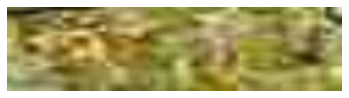

('Actual:', 'ഗവർണ്ണർ', 'Prediction:', 'ന--വ-ർർണ്്ണ-ർ', 'Prediction Corrected:', 'നവർണ്ണർ')


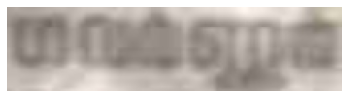

('Actual:', 'അവകാശികൾ', 'Prediction:', 'അ--കകകാനികക-ൾ', 'Prediction Corrected:', 'അകാനികൾ')


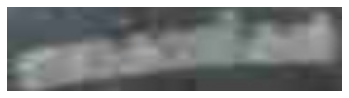

('Actual:', 'ക്ഷാരലോഹങ്ങൾ', 'Prediction:', 'ക്പാഭഭാഹങ്്ങൾ', 'Prediction Corrected:', 'ക്പാഭാഹങ്ങൾ')


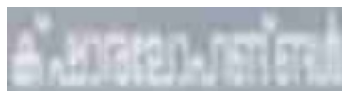

('Actual:', 'ചതുര', 'Prediction:', 'ക----മ------ൻ', 'Prediction Corrected:', 'കമൻ')


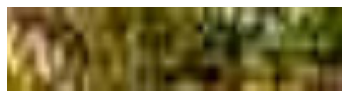

('Actual:', 'ശനി', 'Prediction:', 'ഹ-----------ി', 'Prediction Corrected:', 'ഹി')


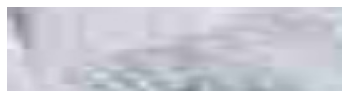

('Actual:', 'മജ്മ', 'Prediction:', 'ഉ-----------ാ', 'Prediction Corrected:', 'ഉാ')


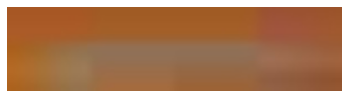

('Actual:', 'അദലജ്', 'Prediction:', 'ജ----സ-----ത്', 'Prediction Corrected:', 'ജസത്')


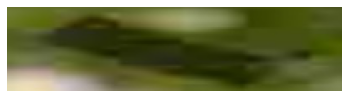

('Actual:', 'ഗദ', 'Prediction:', 'ജ-----------ൻ', 'Prediction Corrected:', 'ജൻ')


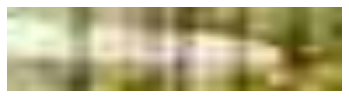

('Actual:', 'കഴ്സർ', 'Prediction:', 'ക---ഴ-ിസ-ൂ--ർ', 'Prediction Corrected:', 'കഴിസൂർ')


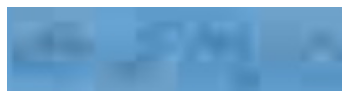

('Actual:', 'അഡെനിയ', 'Prediction:', 'ക---ാസ്തതി--യ', 'Prediction Corrected:', 'കാസ്തിയ')


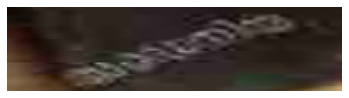

('Actual:', 'പടപ്പറമ്പ്', 'Prediction:', 'പ-----------ൽ', 'Prediction Corrected:', 'പൽ')


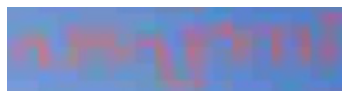

('Actual:', 'ജയപാൽ', 'Prediction:', 'മ--േ--ന-----ക', 'Prediction Corrected:', 'മേനക')


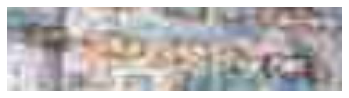

('Actual:', 'ഓവർ', 'Prediction:', 'ഇ-----------ന', 'Prediction Corrected:', 'ഇന')


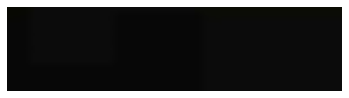

('Actual:', 'കയ്മ', 'Prediction:', 'ക-------സ്്്മ', 'Prediction Corrected:', 'കസ്മ')


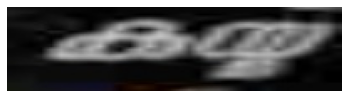

('Actual:', 'അരൂബ', 'Prediction:', 'ആ-----റു----മ', 'Prediction Corrected:', 'ആറുമ')


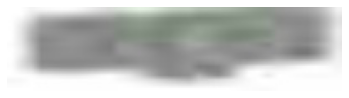

('Actual:', 'വഖഫ്', 'Prediction:', 'മ----ല-----ഫ്', 'Prediction Corrected:', 'മലഫ്')


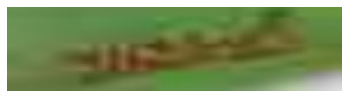

('Actual:', 'മകരെരെ', 'Prediction:', 'മ-കക--ര-----ണ', 'Prediction Corrected:', 'മകരണ')


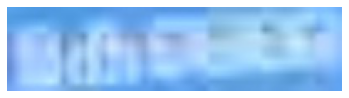

('Actual:', 'റപൂൺ', 'Prediction:', 'ഉ---ഹ-------ൾ', 'Prediction Corrected:', 'ഉഹൾ')


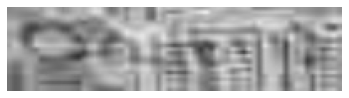

('Actual:', 'പച്ചകുത്തൽ', 'Prediction:', 'ക-----------ൽ', 'Prediction Corrected:', 'കൽ')


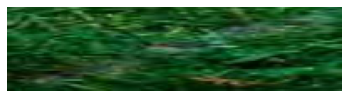

In [32]:
visualize_misclassifications('Test')

('Actual:', 'ആന', 'Prediction:', 'ആ-----------ു', 'Prediction Corrected:', 'ആു')


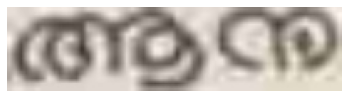

('Actual:', 'മീശ', 'Prediction:', 'ബ-----ി-----ന', 'Prediction Corrected:', 'ബിന')


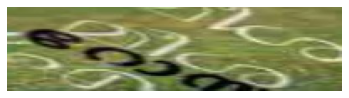

('Actual:', 'ഭവ', 'Prediction:', 'ട-----------വ', 'Prediction Corrected:', 'ടവ')


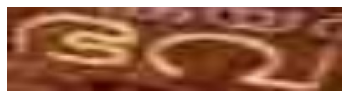

('Actual:', 'ഗഞ്ചിറ', 'Prediction:', 'ഗ---ഞഞ്്ച---റ', 'Prediction Corrected:', 'ഗഞ്ചറ')


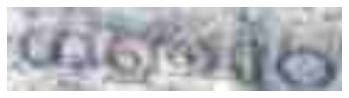

('Actual:', 'ദ്രോണർ', 'Prediction:', 'ദ്്രരേണണ----ർ', 'Prediction Corrected:', 'ദ്രേണർ')


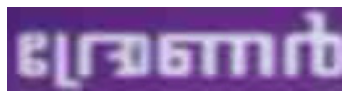

('Actual:', 'ഖ്വബാല', 'Prediction:', 'ഖ----ബ---ാ--ല', 'Prediction Corrected:', 'ഖബാല')


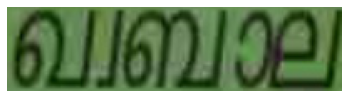

('Actual:', 'മീന', 'Prediction:', 'മ----ി------ന', 'Prediction Corrected:', 'മിന')


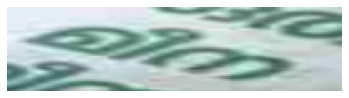

('Actual:', 'അബ്ദുൾ', 'Prediction:', 'അ---ബ-്്ദ---ൾ', 'Prediction Corrected:', 'അബ്ദൾ')


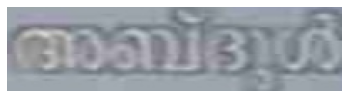

('Actual:', 'യമൻ', 'Prediction:', 'ആ-----------ൻ', 'Prediction Corrected:', 'ആൻ')


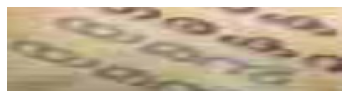

('Actual:', 'കല്ല്യാണരാമൻ', 'Prediction:', 'കല്യാണണരാമമ-ൻ', 'Prediction Corrected:', 'കല്യാണരാമൻ')


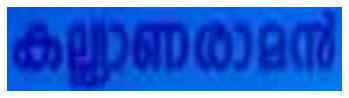

('Actual:', 'അഷ്കർ', 'Prediction:', 'ക---ണണ്ണളൂ--ർ', 'Prediction Corrected:', 'കണ്ണളൂർ')


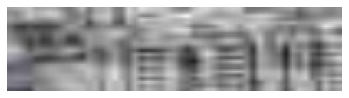

('Actual:', 'എഐ', 'Prediction:', 'ഏ-----ഐ------', 'Prediction Corrected:', 'ഏഐ')


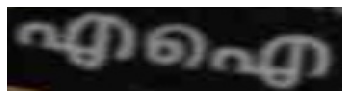

('Actual:', 'പട്രീഷ്യൻ', 'Prediction:', 'പ-ട്ടീഷ്്യ--ൻ', 'Prediction Corrected:', 'പട്ടീഷ്യൻ')


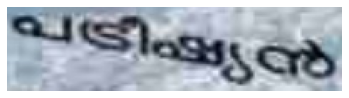

('Actual:', 'നീർക്കടവ്', 'Prediction:', 'ക-ികർക്കടട-വ്', 'Prediction Corrected:', 'കികർക്കടവ്')


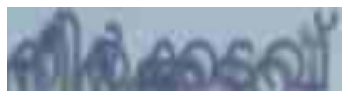

('Actual:', 'കമ്മീഷൻ', 'Prediction:', 'ക--മ്മീക----ൻ', 'Prediction Corrected:', 'കമ്മീകൻ')


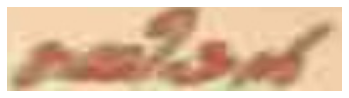

('Actual:', 'ജയവർദ്ധനെ', 'Prediction:', 'ജ-യ-വ-ർദ്-ന-െ', 'Prediction Corrected:', 'ജയവർദ്നെ')


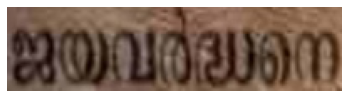

('Actual:', 'അജണ്ട', 'Prediction:', 'അ----ജ------ണ', 'Prediction Corrected:', 'അജണ')


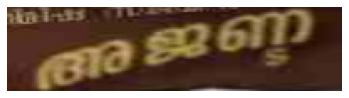

('Actual:', 'അചനൂർ', 'Prediction:', 'അ---ച--ന-നൂ-ർ', 'Prediction Corrected:', 'അചനനൂർ')


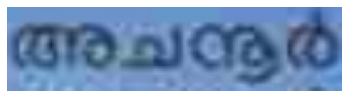

('Actual:', 'ലാറ്ററൻ', 'Prediction:', 'മ--റ്ററററ---ൻ', 'Prediction Corrected:', 'മറ്റൻ')


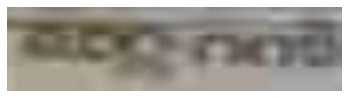

('Actual:', 'കിബ്ബർ', 'Prediction:', 'ക-്--ബബ്ബബൂ-ർ', 'Prediction Corrected:', 'ക്ബ്ബൂർ')


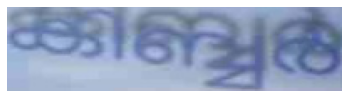

In [33]:
visualize_misclassifications('Test-V2')

### References:
[1] https://github.com/carnotaur/crnn-tutorial/